In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive'   

#%cd '/content/drive/My Drive/Intermediate_Assignment_Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


# Initial Data Processing

With the following code, we load all the images into numpy array and also assign labels (0 if No sunglasses and 1 if sunglasses are present).



In [73]:
#list of all image file names , example="NoSunglasses0.pgm"
filenames=glob.glob("*.pgm")   

#No. of images
m_given=len(filenames)         
print(f"No. of images in the dataset = {m_given}")

#All images will be converted to the shape (128,128)
h=128                  

#Initialize numpy arrays given_X,given_y to store images and labels respectively
given_X=np.zeros((m_given,h,h,1))
given_y=np.zeros((m_given,1))

No. of images in the dataset =624


In [43]:
#Read all the images using imread() function. We assign the label 0 if first later in the image name is 'N' else we assign the label 1. 
for i in range(m_given):
  img=cv2.imread(filenames[i],0)
  img=cv2.resize(img,(h,h))
  img=img.reshape((h,h,1))
  given_X[i]=img
  if filenames[i][0]=='N':
    given_y[i]=0
  else :
    given_y[i]=1

313
311


We will now distribute the data among training , validation and test sets. 
For this we will first shuffle images and corresponding labels.

The distribtion is as follows:

train = 324 images

validation = 100 images

test = 200 images


In [ ]:
#Shuffle all the images we have read in and correspondingly their labels.
pos=np.arange(m_given)
np.random.shuffle(pos)
given_X=given_X[pos]
given_y=given_y[pos]

X_test=given_X[:200]
y_test=given_y[:200]
given_X_valid=given_X[200:300]
given_y_valid=given_y[200:300]
given_X_train=given_X[300:]
given_y_train=given_y[300:]

Clearly the we are running short of images. So we will apply data augmentation technique and enlarge the training and validation dataset by a factor of 20. However, we will not augment test data and keep it as it is.

In [152]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,                                                
    shear_range=0.2,
    zoom_range=[0.8,1.2],                       
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True
)

In [163]:
factor=20  #The factor by which the dataset is to be multiplied
m_train=len(given_y_train)
m_valid=len(given_y_valid)

#generate all training images after augmnetation 
X_train=np.zeros([factor*m_train,h,h,1])                                
y_train=np.zeros([factor*m_train,1])
for i in range(factor):                                                    
  it=train_data_gen.flow(given_X_train,given_y_train,batch_size=m_train)                        
  temp=next(it)
  X_train[i*m_train:(i+1)*m_train,:,:,:]=temp[0]                                 
  y_train[i*m_train:(i+1)*m_train,:]=temp[1]      

#Generate all validation images after augmnetation
X_valid=np.zeros([factor*m_valid,h,h,1])                                
y_valid=np.zeros([factor*m_valid,1])
for i in range(factor):                                                    
  it=valid_data_gen.flow(given_X_valid,given_y_valid,batch_size=m_valid)                        
  temp=next(it)
  X_valid[i*m_valid:(i+1)*m_valid,:,:,:]=temp[0]                                 
  y_valid[i*m_valid:(i+1)*m_valid,:]=temp[1]                                    
                                                                      


Thus after all data augmnetation we have :

**No. of training images = 6480 generated from 324 images.**

**No. of validation images = 2000 generated from 100 images.**

**No. of test images = 200 generated from 200 images.**

In [164]:
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

We now save the images and labels into .npy files for easy reference later on.

In [168]:
np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)
np.save('X_test',X_test)
np.save('y_test',y_test)

# Load processed data

After we have processed the above code once, we can simply load the images from numpy files everytime we start working.

In [5]:
X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

#get the shape of image which is (h,h)
h=X_train.shape[1]
print(h)

128


# Quick peek into some examples

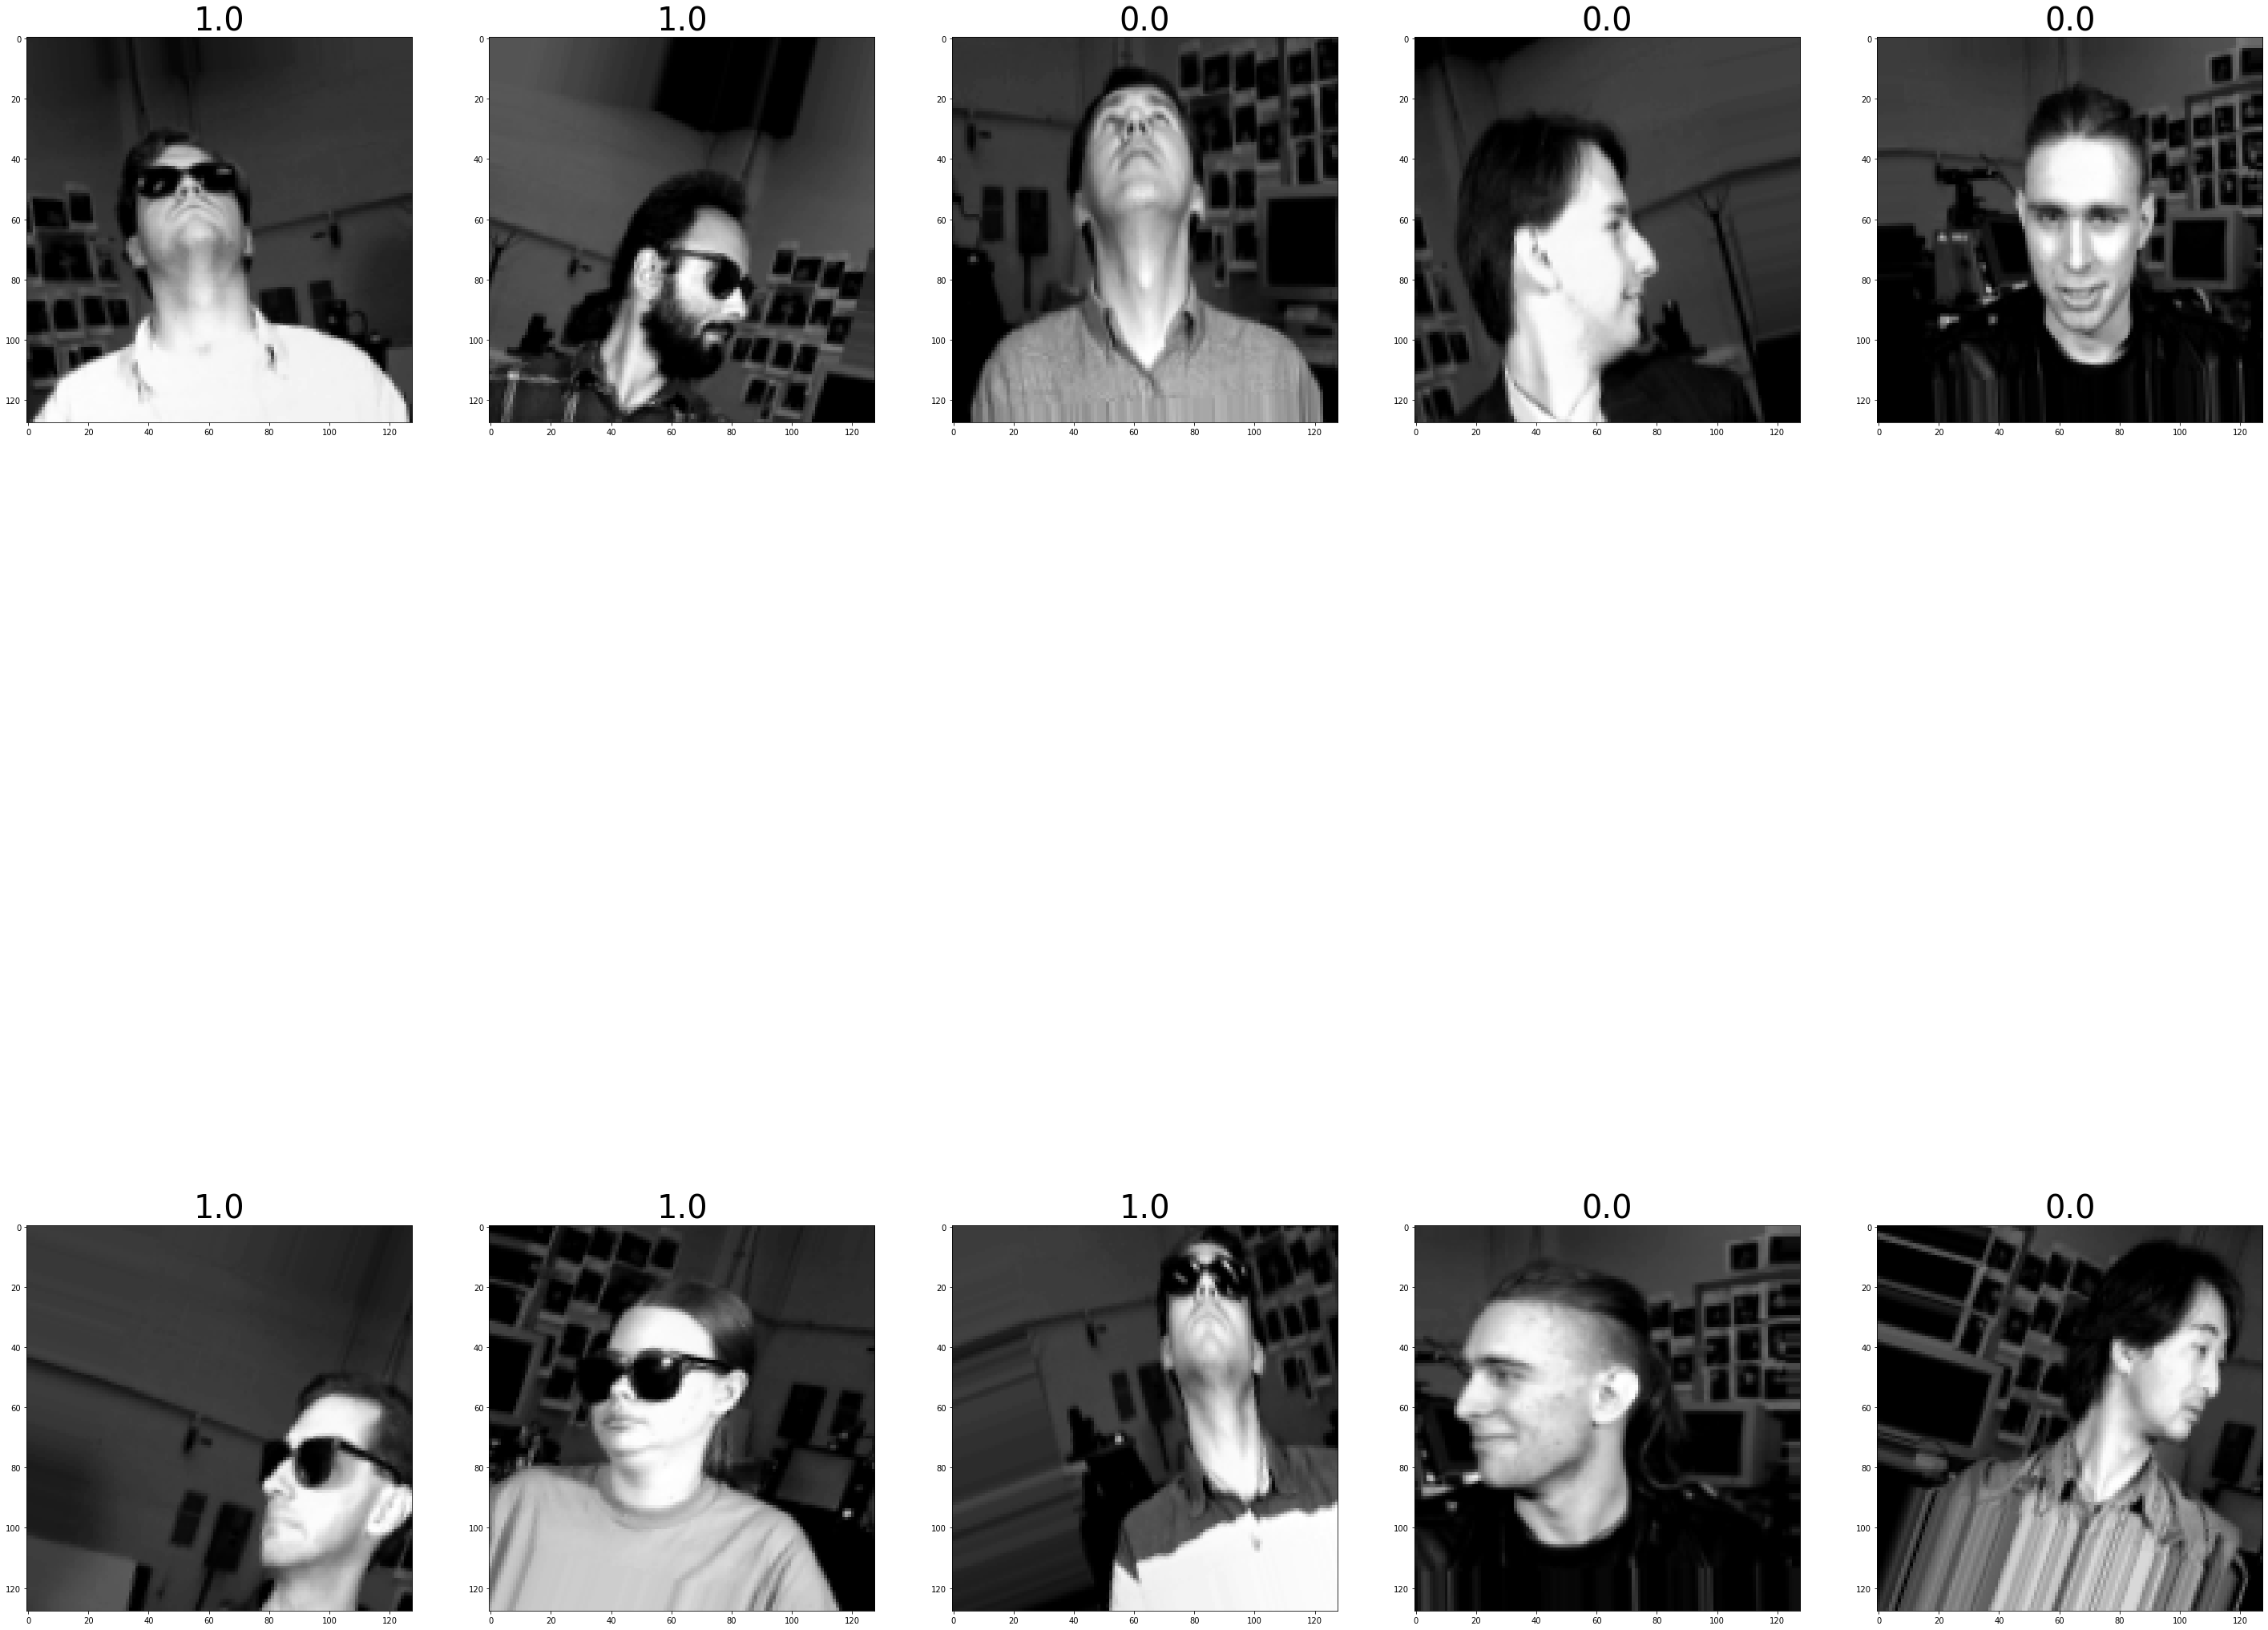

In [6]:
fig=plt.figure(figsize=(50,50))   
for i in range(10):
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i].copy()
  img=img.reshape((h,h))
  sub.imshow(img.astype(np.uint8),cmap='gray')
  plt.title(y_train[i][0],fontsize=40)        
plt.show()

# Building and training the model

In [7]:
#Normalizing all the images 
X_train=X_train/255.0
X_valid=X_valid/255.0
X_test=X_test/255.0

We now define the model. 

We will optimize it with 'adagrad' and use 'binary crossentropy' loss. We will train with batch size of 64.

In [35]:
model=tf.keras.Sequential([
       Conv2D(32,3,1,padding='same',activation='relu',
              input_shape=(h,h,1)),
       Conv2D(32,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),

       Conv2D(64,3,1,padding='same',activation='relu'),
       Conv2D(64,3,1,padding='same',activation='relu'),
       Conv2D(64,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),
       BatchNormalization(),

       Conv2D(128,3,1,padding='same',activation='relu'),
       Conv2D(128,3,1,padding='same',activation='relu'),
       Conv2D(128,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),

       Conv2D(32,3,1,padding='same',activation='relu'),
       Conv2D(256,3,1,padding='same',activation='relu'),
       MaxPool2D(2,2,padding='valid'),
       BatchNormalization(),

       Flatten(),
       Dense(1,activation='sigmoid')
])

model.compile(optimizer='adagrad',loss='binary_crossentropy',metrics=['accuracy','Precision','Recall'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)       

In [36]:
epochs=20
history=model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
102/102 [==============================] - 7s 70ms/step - loss: 0.2590 - accuracy: 0.8770 - precision: 0.9011 - recall: 0.8536 - val_loss: 0.6841 - val_accuracy: 0.5100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
102/102 [==============================] - 7s 66ms/step - loss: 0.0352 - accuracy: 0.9912 - precision: 0.9979 - recall: 0.9849 - val_loss: 0.7537 - val_accuracy: 0.5100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
102/102 [==============================] - 7s 66ms/step - loss: 0.0166 - accuracy: 0.9960 - precision: 0.9988 - recall: 0.9934 - val_loss: 1.2766 - val_accuracy: 0.5100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
102/102 [==============================] - 7s 66ms/step - loss: 0.0133 - accuracy: 0.9961 - precision: 0.9982 - recall: 0.9943 - val_loss: 0.7834 - val_accuracy: 0.5610 - val_precision: 1.0000 - val_recall: 0.1041
Epoch 5/20
102/102 [==============================] - 7s 66ms/step - loss: 0

We will now plot the results against epoch.

Text(0.5, 1.0, 'Training and Validation Accuracy')

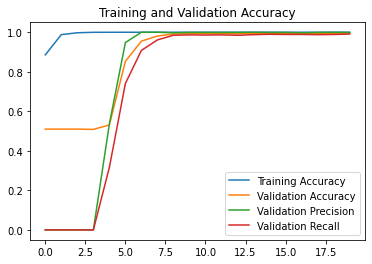

In [31]:
acc=history.history['accuracy']
loss=history.history['loss']
precision=history.history['precision']
recall=history.history['recall']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
val_precision=history.history['val_precision']
val_recall=history.history['val_recall']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


# Testing the model

In [62]:
#Evaluate accuracy, precision and recall on the test set
model.evaluate(X_test,y_test,batch_size=1)

200/200 [==============================] - 1s 4ms/step - loss: 0.0643 - accuracy: 0.9900 - precision: 0.9896 - recall: 0.9896


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[103,   1],
       [  1,  95]], dtype=int32)>

In [ ]:
#display the confusion matrix. here 0th axis is represents true labels and 1st axis represents predicted labels
predictions=model.predict(X_test).astype(float)
tf.math.confusion_matrix(y_test.reshape(200,),predictions>0.5)

In [40]:
#Save the model
model.save("assignment9900.h5")